# **Dataset Preparation Script for Challenge 1 - Predicting Solar Output**

### Modeling Assumptions
- The Kaggle Australia weather training file does not expose explicit calendar dates; we assign synthetic dates starting from July 1, 2016 to match Australian weather patterns (winter start).
- Each location has 365 daily observations representing a full year of weather data.
- Solar values extracted from monthly rasters are used to generate synthetic daily PV output with realistic variation around monthly averages.
- **Important**: Monthly PVOUT values from Global Solar Atlas already incorporate ALL physical factors: average weather patterns (clouds, rainfall) AND average solar geometry (day length, sun angle) for each month. Daily synthetic values are generated as monthly baseline + random noise, allowing ML models to learn how daily weather deviations predict solar output variations.
- Daily solar values are in kWh/kWp for each city's footprint and serve as the target variable.

In [37]:
import rasterio
from rasterio.plot import show, plotting_extent
from rasterio.windows import from_bounds, Window
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

## **Exploratory Data Analysis**

In [38]:
file_path = "data/australia-weather-data/Weather Training Data.csv"
df = pd.read_csv(file_path)

# Group by location and take first 365 rows for each location to ensure we have exactly one year per location
df = df.groupby("Location").head(365).reset_index(drop=True)

# Create synthetic dates for each location (starting July 1, 2016 - Australian winter)
# This aligns with Southern Hemisphere seasons
df["Date"] = (
    df.groupby("Location")
    .cumcount()
    .apply(lambda x: pd.Timestamp("2016-07-01") + pd.Timedelta(days=int(x)))
)

# Add month column for joining with solar data
df["Month"] = df["Date"].dt.month

print("Dataset Head:")
display(df.head())

print("\nDataset Info:")
df.info()

print("\nSummary Statistics:")
display(df.describe())

print(f"\nDate range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Total observations: {len(df)}")
print(f"Observations per location: {df.groupby('Location').size().unique()}")

Dataset Head:


,row ID,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Date,Month
0,Row0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0,2016-07-01,7
1,Row1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0,2016-07-02,7
2,Row2,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0,2016-07-03,7
3,Row3,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,...,1009.2,1005.4,NaN,NaN,20.6,28.9,No,0,2016-07-04,7
4,Row4,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,...,1013.4,1010.1,NaN,NaN,16.3,25.5,No,0,2016-07-05,7



Dataset Info:
<class 'pandas.DataFrame'>
RangeIndex: 17885 entries, 0 to 17884
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   row ID         17885 non-null  str           
 1   Location       17885 non-null  str           
 2   MinTemp        17760 non-null  float64       
 3   MaxTemp        17821 non-null  float64       
 4   Rainfall       17720 non-null  float64       
 5   Evaporation    11388 non-null  float64       
 6   Sunshine       10789 non-null  float64       
 7   WindGustDir    16473 non-null  str           
 8   WindGustSpeed  16476 non-null  float64       
 9   WindDir9am     16647 non-null  str           
 10  WindDir3pm     17546 non-null  str           
 11  WindSpeed9am   17662 non-null  float64       
 12  WindSpeed3pm   17681 non-null  float64       
 13  Humidity9am    17636 non-null  float64       
 14  Humidity3pm    17592 non-null  float64       
 15  Pressure9am    

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow,Date,Month
count,17760.000000,17821.000000,17720.000000,11388.000000,10789.000000,16476.000000,17662.000000,17681.000000,17636.000000,17592.000000,16349.000000,16349.000000,11723.000000,11510.000000,17703.000000,17691.000000,17885.000000,17885,17885.000000
mean,12.729144,24.003709,2.208132,5.587987,7.843424,40.854212,14.359472,19.196312,67.335223,49.611073,1016.917426,1014.499976,4.112087,4.271416,17.498718,22.553790,0.214314,2016-12-30 00:00:00,6.526027
min,-8.500000,-2.700000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,2.000000,1.000000,980.500000,979.000000,0.000000,0.000000,-5.900000,-5.100000,0.000000,2016-07-01 00:00:00,1.000000
25%,8.200000,18.600000,0.000000,2.800000,5.100000,31.000000,7.000000,13.000000,56.000000,34.000000,1012.400000,1009.800000,1.000000,1.000000,12.800000,17.300000,0.000000,2016-09-30 00:00:00,4.000000
50%,12.500000,23.400000,0.000000,5.000000,8.800000,39.000000,13.000000,19.000000,69.000000,51.000000,1017.100000,1014.600000,4.000000,5.000000,17.200000,22.000000,0.000000,2016-12-30 00:00:00,7.000000
75%,17.400000,29.300000,0.600000,7.400000,10.800000,48.000000,20.000000,24.000000,82.000000,64.000000,1021.700000,1019.300000,7.000000,7.000000,22.100000,27.550000,0.000000,2017-03-31 00:00:00,10.000000
max,33.900000,46.800000,371.000000,81.200000,14.300000,124.000000,83.000000,87.000000,100.000000,100.000000,1039.900000,1037.900000,8.000000,8.000000,37.900000,46.100000,1.000000,2017-06-30 00:00:00,12.000000
std,6.291182,7.286669,8.320224,3.940864,3.770576,13.600620,8.913175,8.809509,19.386137,21.245996,6.856496,6.827029,2.863658,2.684047,6.498583,7.141772,0.410357,NaN,3.447948



Date range: 2016-07-01 00:00:00 to 2017-06-30 00:00:00
Total observations: 17885
Observations per location: [365]


In [39]:
print(
    f"\nNumber of rows in the dataset (49 locations x 365 days = {49 * 365}): {len(df)}"
)


Number of rows in the dataset (49 locations x 365 days = 17885): 17885


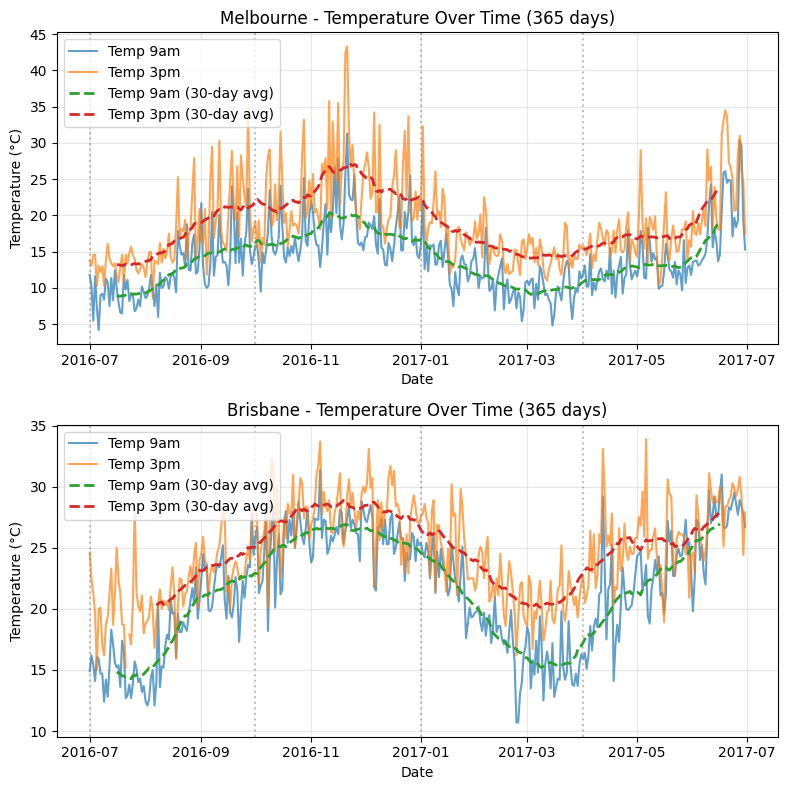

In [40]:
# Verify temperature features show reasonable seasonal patterns
# Plot Temp9am and Temp3pm for sample locations to confirm data quality

sample_locations = ["Melbourne", "Brisbane"]

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
axes = axes.flatten()

for idx, location in enumerate(sample_locations):
    ax = axes[idx]
    location_data = df[df["Location"] == location].sort_values("Date")
    
    if len(location_data) > 0:
        # Plot temperature features
        ax.plot(location_data["Date"], location_data["Temp9am"], 
                label="Temp 9am", alpha=0.7, linewidth=1.5)
        ax.plot(location_data["Date"], location_data["Temp3pm"], 
                label="Temp 3pm", alpha=0.7, linewidth=1.5)
        
        # Add rolling average to show seasonal trend
        ax.plot(location_data["Date"], 
                location_data["Temp9am"].rolling(window=30, center=True).mean(),
                "--", label="Temp 9am (30-day avg)", linewidth=2)
        ax.plot(location_data["Date"], 
                location_data["Temp3pm"].rolling(window=30, center=True).mean(),
                "--", label="Temp 3pm (30-day avg)", linewidth=2)
        
        ax.set_xlabel("Date")
        ax.set_ylabel("Temperature (°C)")
        ax.set_title(f"{location} - Temperature Over Time (365 days)")
        ax.legend(loc="best")
        ax.grid(True, alpha=0.3)
        
        # Add month labels
        ax.axvline(pd.Timestamp("2016-07-01"), color="gray", linestyle=":", alpha=0.5)
        ax.axvline(pd.Timestamp("2016-10-01"), color="gray", linestyle=":", alpha=0.5)
        ax.axvline(pd.Timestamp("2017-01-01"), color="gray", linestyle=":", alpha=0.5)
        ax.axvline(pd.Timestamp("2017-04-01"), color="gray", linestyle=":", alpha=0.5)

plt.tight_layout()
plt.show()

## **Data Visualization**
We will visualize the distribution of key features and their relationships in the Weather dataset.

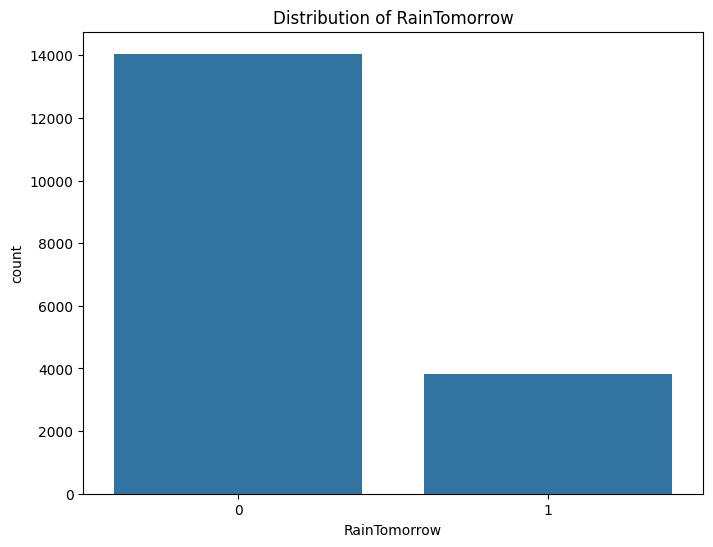

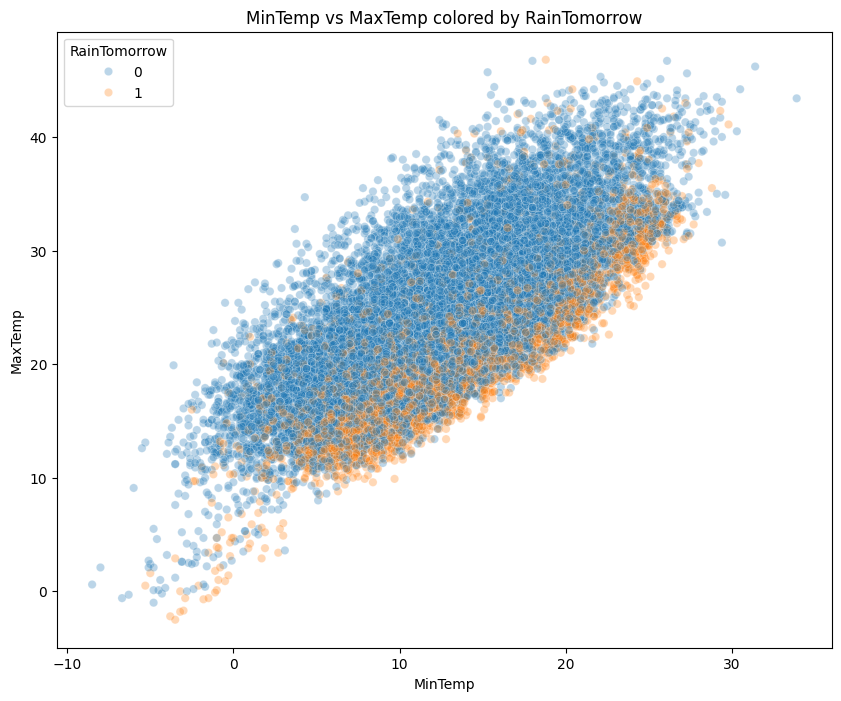

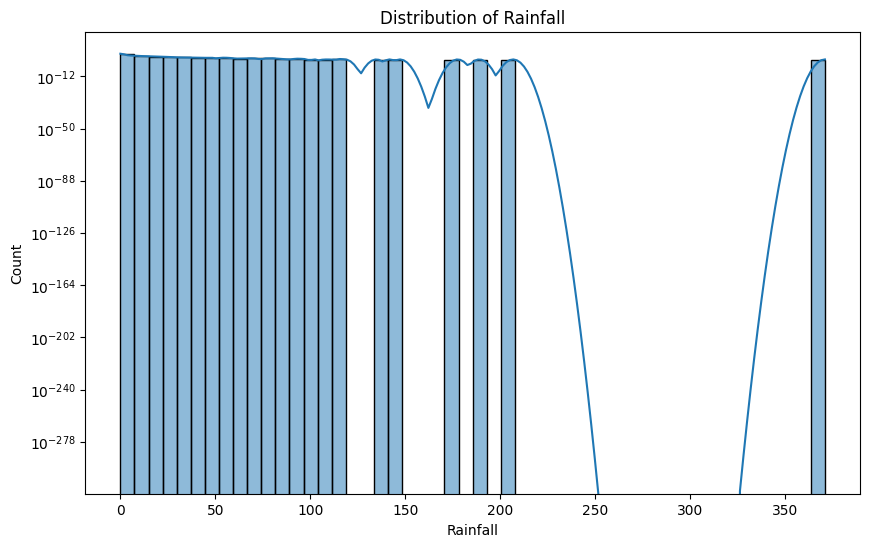

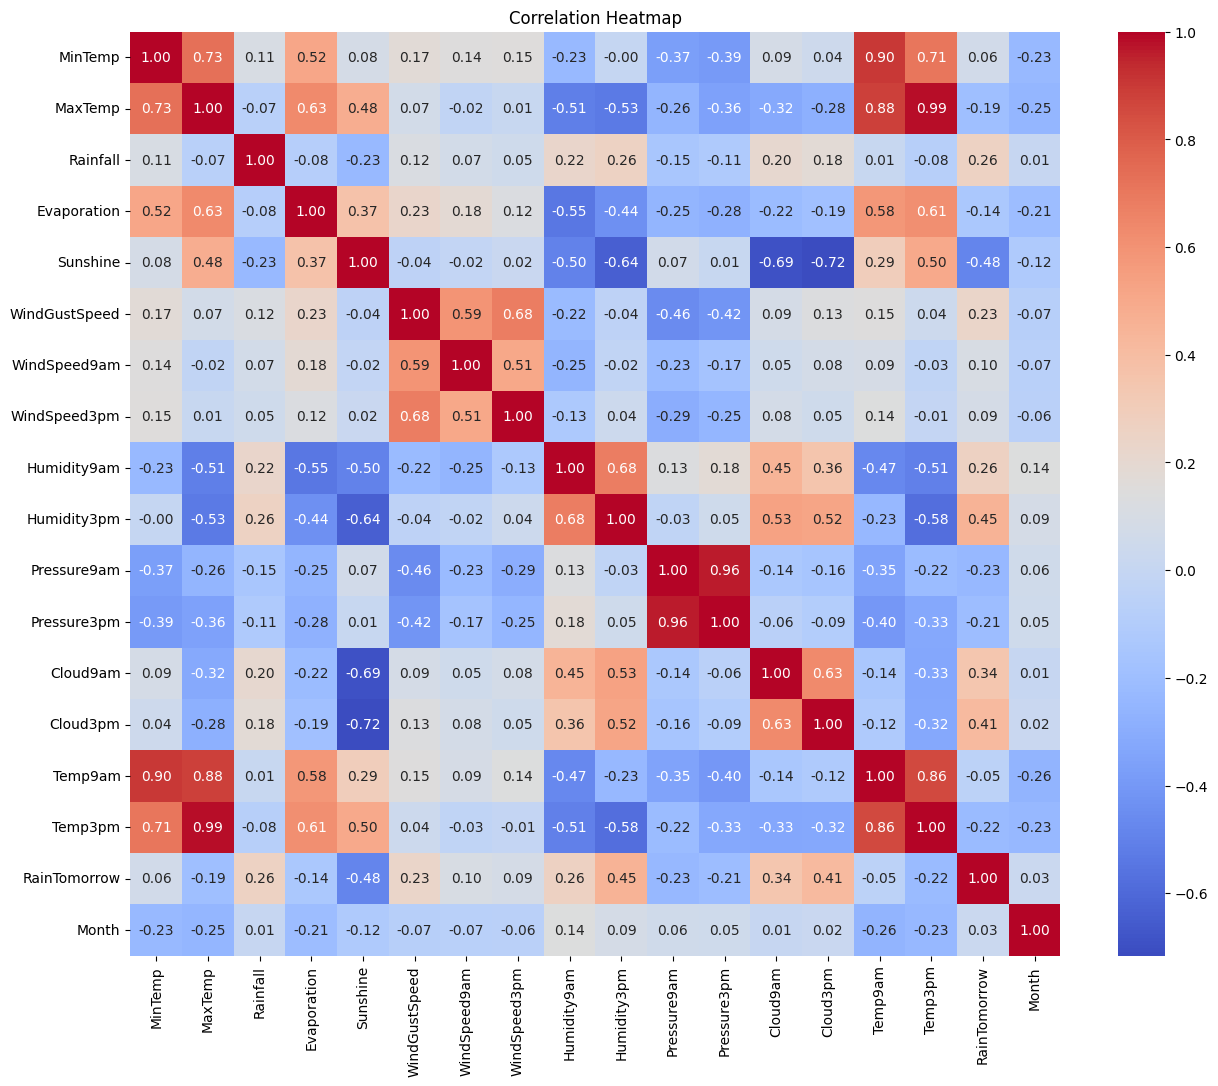

In [41]:
# 1. Target Distribution: RainTomorrow
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="RainTomorrow")
plt.title("Distribution of RainTomorrow")
plt.show()

# 2. Relationship between MinTemp and MaxTemp
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x="MinTemp", y="MaxTemp", hue="RainTomorrow", alpha=0.3)
plt.title("MinTemp vs MaxTemp colored by RainTomorrow")
plt.show()

# 3. Distribution of Rainfall (log scale because it's usually skewed)
plt.figure(figsize=(10, 6))
sns.histplot(df["Rainfall"].dropna(), kde=True, bins=50)
plt.title("Distribution of Rainfall")
plt.yscale("log")
plt.show()

# 4. Correlation Heatmap
plt.figure(figsize=(15, 12))
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

## **PV Output Raster**
Next, we visualize the compiled PV output raster that summarizes the monthly solar resource over the entire region.

PVOUT raster CRS: EPSG:4326
Bounds: BoundingBox(left=112.0, bottom=-44.0, right=160.0, top=-9.0)


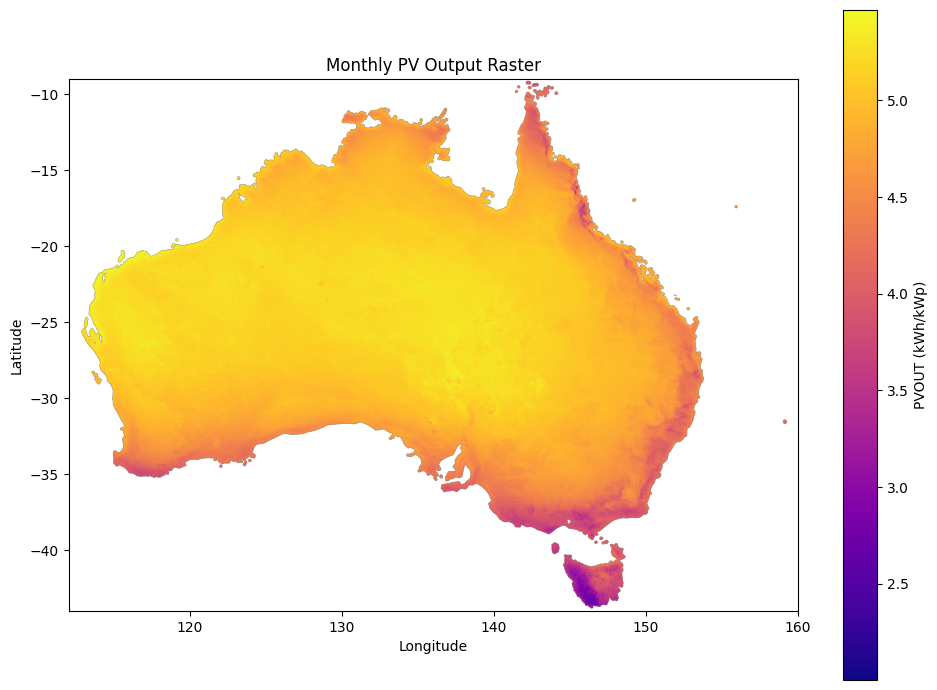

In [42]:
pvout_path = "data/solar-data/PVOUT.tif"

with rasterio.open(pvout_path) as src:
    pvout = src.read(1, masked=True)
    transform = src.transform
    print("PVOUT raster CRS:", src.crs)
    print("Bounds:", src.bounds)

extent = plotting_extent(pvout, transform)

fig, ax = plt.subplots(figsize=(10, 7))
img = ax.imshow(pvout, cmap="plasma", extent=extent, origin="upper")
fig.colorbar(img, ax=ax, label="PVOUT (kWh/kWp)")
ax.set_title("Monthly PV Output Raster")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()

### **PV Output Distribution**
We inspect the same raster's value range so we can align modeling decisions with the observed energy output magnitudes.

PVOUT value summary (kWh/kWp):


count    1.047458e+07
mean     4.924682e+00
std      3.624727e-01
min      2.003000e+00
1%       3.701000e+00
5%       4.165000e+00
10%      4.432000e+00
25%      4.783000e+00
50%      5.035000e+00
75%      5.183000e+00
90%      5.240000e+00
95%      5.267000e+00
99%      5.312000e+00
max      5.467000e+00
Name: PVOUT, dtype: float64

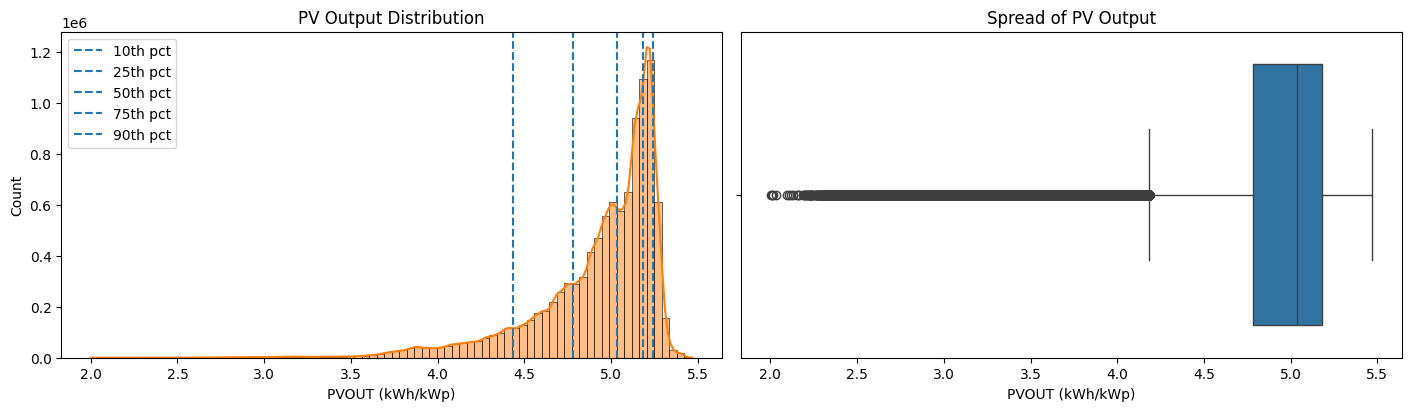

In [43]:
pvout_vals = pvout.compressed()
pvout_series = pd.Series(pvout_vals, name="PVOUT").dropna()
quantile_labels = {
    "10th": pvout_series.quantile(0.1),
    "25th": pvout_series.quantile(0.25),
    "50th": pvout_series.quantile(0.5),
    "75th": pvout_series.quantile(0.75),
    "90th": pvout_series.quantile(0.9),
}

stats_df = pvout_series.describe(
    percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
)
print("PVOUT value summary (kWh/kWp):")
display(stats_df)

fig, axes = plt.subplots(1, 2, figsize=(14, 4), constrained_layout=True)

sns.histplot(pvout_series, bins=80, kde=True, ax=axes[0], color="#ff7f0e")
for label, q_value in quantile_labels.items():
    axes[0].axvline(q_value, linestyle="--", label=f"{label} pct")
axes[0].set_title("PV Output Distribution")
axes[0].set_xlabel("PVOUT (kWh/kWp)")
axes[0].set_ylabel("Count")
axes[0].legend()

sns.boxplot(x=pvout_series, ax=axes[1], color="#1f77b4")
axes[1].set_title("Spread of PV Output")
axes[1].set_xlabel("PVOUT (kWh/kWp)")

plt.show()

### **City-level Solar Dataset for Modeling**
For simplicity purposes, we map each weather station to a representative latitude/longitude sourced from https://simplemaps.com/data/au-cities and sample the Global Solar Atlas PVOUT over a 0.16° × 0.16° box (≈15-20 km²) centered around those points. The aggregated solar values are treated as the year's summary output so they can be aligned with the weather data that will serve as regressors.

In [44]:
# Load city coordinates from au.csv
au_cities = pd.read_csv("data/au.csv")
print(f"Loaded {len(au_cities)} cities from au.csv")
display(au_cities.head())

# Get unique locations from weather dataset
weather_locations = df["Location"].unique()
print(f"\n{len(weather_locations)} unique locations in weather dataset:")
print(sorted(weather_locations))

Loaded 317 cities from au.csv


,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,Melbourne,-37.8142,144.9631,Australia,AU,Victoria,admin,5031195,5031195
1,Sydney,-33.8678,151.2100,Australia,AU,New South Wales,admin,4840600,4840600
2,Brisbane,-27.4678,153.0281,Australia,AU,Queensland,admin,2360241,2360241
3,Perth,-31.9559,115.8606,Australia,AU,Western Australia,admin,2141834,2141834
4,Adelaide,-34.9275,138.6000,Australia,AU,South Australia,admin,1295714,1295714



49 unique locations in weather dataset:
['Adelaide', 'Albany', 'Albury', 'AliceSprings', 'BadgerysCreek', 'Ballarat', 'Bendigo', 'Brisbane', 'Cairns', 'Canberra', 'Cobar', 'CoffsHarbour', 'Dartmoor', 'Darwin', 'GoldCoast', 'Hobart', 'Katherine', 'Launceston', 'Melbourne', 'MelbourneAirport', 'Mildura', 'Moree', 'MountGambier', 'MountGinini', 'Newcastle', 'Nhil', 'NorahHead', 'NorfolkIsland', 'Nuriootpa', 'PearceRAAF', 'Penrith', 'Perth', 'PerthAirport', 'Portland', 'Richmond', 'Sale', 'SalmonGums', 'Sydney', 'SydneyAirport', 'Townsville', 'Tuggeranong', 'Uluru', 'WaggaWagga', 'Walpole', 'Watsonia', 'Williamtown', 'Witchcliffe', 'Wollongong', 'Woomera']


In [45]:
no_coords_count = 0
for loc in weather_locations:
    if loc not in au_cities["city"].values:
        no_coords_count += 1
    else:
        print(f"Direct match: {loc}")
print(
    f"\nTotal locations without coordinates: {no_coords_count}/{len(df["Location"].unique())}"
)

Direct match: Albury
Direct match: Cobar
Direct match: Moree
Direct match: Newcastle
Direct match: Penrith
Direct match: Richmond
Direct match: Sydney
Direct match: Wollongong
Direct match: Canberra
Direct match: Ballarat
Direct match: Bendigo
Direct match: Melbourne
Direct match: Brisbane
Direct match: Cairns
Direct match: Townsville
Direct match: Adelaide
Direct match: Nuriootpa
Direct match: Perth
Direct match: Hobart
Direct match: Launceston
Direct match: Darwin

Total locations without coordinates: 28/49


In [46]:
# Create mapping from weather station names to au.csv city names
# Handle naming variations and special cases

location_name_mapping = {
    # Direct matches (will use city name as-is)
    "Albury": "Albury",
    "Brisbane": "Brisbane",
    "Cairns": "Cairns",
    "Canberra": "Canberra",
    "Hobart": "Hobart",
    "Launceston": "Launceston",
    "Melbourne": "Melbourne",
    "Newcastle": "Newcastle",
    "Perth": "Perth",
    "Sydney": "Sydney",
    "Adelaide": "Adelaide",
    "Darwin": "Darwin",
    "Townsville": "Townsville",
    "Ballarat": "Ballarat",
    "Bendigo": "Bendigo",
    "Penrith": "Penrith",
    # Compound names / Airports (use closest major city)
    "BadgerysCreek": "Penrith",  # Western Sydney
    "Cobar": "Cobar",
    "CoffsHarbour": None,  # Not in au.csv, will use manual coordinates
    "Moree": "Moree",
    "NorahHead": "Central Coast",
    "NorfolkIsland": None,  # Special case - not in mainland au.csv
    "Richmond": "Richmond",
    "SydneyAirport": "Sydney",
    "WaggaWagga": "Wagga Wagga",
    "Williamtown": "Newcastle",  # Near Newcastle
    "Wollongong": "Wollongong",
    "Tuggeranong": "Canberra",  # Canberra suburb
    "MountGinini": "Canberra",  # Near Canberra
    "Sale": None,  # Not in au.csv, will use manual coordinates
    "MelbourneAirport": "Melbourne",
    "Mildura": None,  # Not in au.csv, will use manual coordinates
    "Nhil": None,  # Small town, may need manual coordinates
    "Portland": None,  # Not in au.csv, will use manual coordinates
    "Watsonia": "Melbourne",  # Melbourne suburb
    "Dartmoor": None,  # Small town, may need manual coordinates
    "GoldCoast": "Gold Coast",
    "MountGambier": "Mount Gambier",
    "Nuriootpa": "Nuriootpa",
    "Woomera": None,  # Remote location, may need manual coordinates
    "Albany": None,  # Not in au.csv, will use manual coordinates
    "Witchcliffe": None,  # Small town in WA
    "PearceRAAF": "Perth",  # Near Perth
    "PerthAirport": "Perth",
    "SalmonGums": None,  # Small town in WA
    "Walpole": None,  # Not in au.csv, will use manual coordinates
    "AliceSprings": None,  # Not in au.csv (inland NT)
    "Katherine": None,  # Not in au.csv, will use manual coordinates
    "Uluru": None,  # Special case - remote location
}

# Build city_coords dictionary from au.csv
city_coords = {}
manual_coords_needed = []

for weather_loc, au_city_name in location_name_mapping.items():
    if au_city_name is None:
        # These need manual coordinates
        manual_coords_needed.append(weather_loc)
    else:
        # Try to find in au.csv
        city_match = au_cities[au_cities["city"] == au_city_name]
        if len(city_match) > 0:
            lat = city_match.iloc[0]["lat"]
            lng = city_match.iloc[0]["lng"]
            city_coords[weather_loc] = (lat, lng)
        else:
            # City name not found in au.csv
            manual_coords_needed.append(weather_loc)
            print(f"'{au_city_name}' not found in au.csv for location '{weather_loc}'")

# Add manual coordinates for locations not in au.csv
# These coordinates are looked up separately
manual_coordinates_supplement = {
    "NorfolkIsland": (-29.0278, 167.9486),
    "Nhil": (-36.2135, 141.9330),
    "Dartmoor": (-37.9900, 141.4600),
    "Woomera": (-31.1667, 136.8167),
    "Witchcliffe": (-34.0532, 115.1583),
    "SalmonGums": (-32.0481, 121.9393),
    "AliceSprings": (-23.6980, 133.8807),
    "Uluru": (-25.3444, 131.0369),
    "CoffsHarbour": (-30.2963, 153.1133),
    "Sale": (-38.1080, 147.0663),
    "Mildura": (-34.1850, 142.1629),
    "Portland": (-38.3450, 141.6058),
    "Albany": (-35.0247, 117.8840),
    "Walpole": (-34.9553, 116.7374),
    "Katherine": (-14.4658, 132.2630),
}

# Add manual coordinates to city_coords
city_coords.update(manual_coordinates_supplement)

# Verify all weather locations are mapped
weather_locations = df["Location"].unique()
print(f"Successfully mapped {len(city_coords)} / {len(weather_locations)} locations")

missing_locations = set(weather_locations) - set(city_coords.keys())
if missing_locations:
    print(f"Missing coordinates for {len(missing_locations)} locations:")
    for loc in sorted(missing_locations):
        print(f"  - {loc}")

Successfully mapped 49 / 49 locations


In [47]:
city_coords

{'Albury': (np.float64(-36.0806), np.float64(146.9158)),
 'Brisbane': (np.float64(-27.4678), np.float64(153.0281)),
 'Cairns': (np.float64(-16.92), np.float64(145.78)),
 'Canberra': (np.float64(-35.2931), np.float64(149.1269)),
 'Hobart': (np.float64(-42.8806), np.float64(147.325)),
 'Launceston': (np.float64(-41.4419), np.float64(147.145)),
 'Melbourne': (np.float64(-37.8142), np.float64(144.9631)),
 'Newcastle': (np.float64(-32.9167), np.float64(151.75)),
 'Perth': (np.float64(-31.9559), np.float64(115.8606)),
 'Sydney': (np.float64(-33.8678), np.float64(151.21)),
 'Adelaide': (np.float64(-34.9275), np.float64(138.6)),
 'Darwin': (np.float64(-12.4381), np.float64(130.8411)),
 'Townsville': (np.float64(-19.25), np.float64(146.8167)),
 'Ballarat': (np.float64(-37.5608), np.float64(143.8475)),
 'Bendigo': (np.float64(-36.75), np.float64(144.2667)),
 'Penrith': (np.float64(-33.7511), np.float64(150.6942)),
 'BadgerysCreek': (np.float64(-33.7511), np.float64(150.6942)),
 'Cobar': (np.floa

In [48]:
# Add the city_coords to the dataframe
df["Latitude"] = df["Location"].map(lambda loc: city_coords.get(loc, (None, None))[0])
df["Longitude"] = df["Location"].map(lambda loc: city_coords.get(loc, (None, None))[1])

# Verify the mapping
print(f"Added coordinates for {df['Latitude'].notna().sum()} / {len(df)} rows")
print(
    f"\nLocations with missing coordinates: {df[df['Latitude'].isna()]['Location'].unique().tolist()}"
)

print("\nDataframe with coordinates:")
display(df[["Location", "Date", "Latitude", "Longitude"]].head(10))

Added coordinates for 17885 / 17885 rows

Locations with missing coordinates: []

Dataframe with coordinates:


,Location,Date,Latitude,Longitude
0,Albury,2016-07-01,-36.0806,146.9158
1,Albury,2016-07-02,-36.0806,146.9158
2,Albury,2016-07-03,-36.0806,146.9158
3,Albury,2016-07-04,-36.0806,146.9158
4,Albury,2016-07-05,-36.0806,146.9158
5,Albury,2016-07-06,-36.0806,146.9158
6,Albury,2016-07-07,-36.0806,146.9158
7,Albury,2016-07-08,-36.0806,146.9158
8,Albury,2016-07-09,-36.0806,146.9158
9,Albury,2016-07-10,-36.0806,146.9158


In [49]:
# Extract monthly average solar data from TIFF files
solar_monthly_dir = Path("data/solar-data/monthly")
monthly_paths = sorted(
    solar_monthly_dir.glob("PVOUT_*.tif"), key=lambda p: int(p.stem.split("_")[-1])
)
buffer_deg = 0.08
solar_records = []

for month_path in monthly_paths:
    month_number = int(month_path.stem.split("_")[-1])
    month_label = pd.Timestamp(year=2016, month=month_number, day=1).strftime("%b")
    with rasterio.open(month_path) as src:
        for city, (lat, lon) in city_coords.items():
            window = from_bounds(
                lon - buffer_deg,
                lat - buffer_deg,
                lon + buffer_deg,
                lat + buffer_deg,
                src.transform,
            )
            row_start = int(np.floor(window.row_off))
            col_start = int(np.floor(window.col_off))
            row_stop = int(np.ceil(window.row_off + window.height))
            col_stop = int(np.ceil(window.col_off + window.width))
            height = max(1, row_stop - row_start)
            width = max(1, col_stop - col_start)
            tight_window = Window(col_start, row_start, width, height)
            data = src.read(
                1, window=tight_window, masked=True, boundless=True, fill_value=np.nan
            )
            avg_value = float(data.mean()) if data.size else np.nan
            solar_records.append(
                {
                    "Location": city,
                    "Month": month_number,
                    "month_label": month_label,
                    "pvout_monthly_avg": avg_value,
                }
            )

solar_monthly_df = (
    pd.DataFrame(solar_records)
    .dropna(subset=["pvout_monthly_avg"])
    .reset_index(drop=True)
)

print(f"Monthly solar averages extracted: {len(solar_monthly_df)} records")
display(solar_monthly_df.head(12))

/var/folders/0_/mjcn_20x08nfpt2yg090ghtr0000gn/T/ipykernel_7441/573052255.py:31: UserWarning: Warning: converting a masked element to nan.
  avg_value = float(data.mean()) if data.size else np.nan


Monthly solar averages extracted: 576 records


,Location,Month,month_label,pvout_monthly_avg
0,Albury,1,Jan,5.392093
1,Brisbane,1,Jan,4.196017
2,Cairns,1,Jan,4.154005
3,Canberra,1,Jan,5.068012
4,Hobart,1,Jan,4.685323
5,Launceston,1,Jan,5.227579
6,Melbourne,1,Jan,5.024319
7,Newcastle,1,Jan,4.658405
8,Perth,1,Jan,5.702655
9,Sydney,1,Jan,4.451422


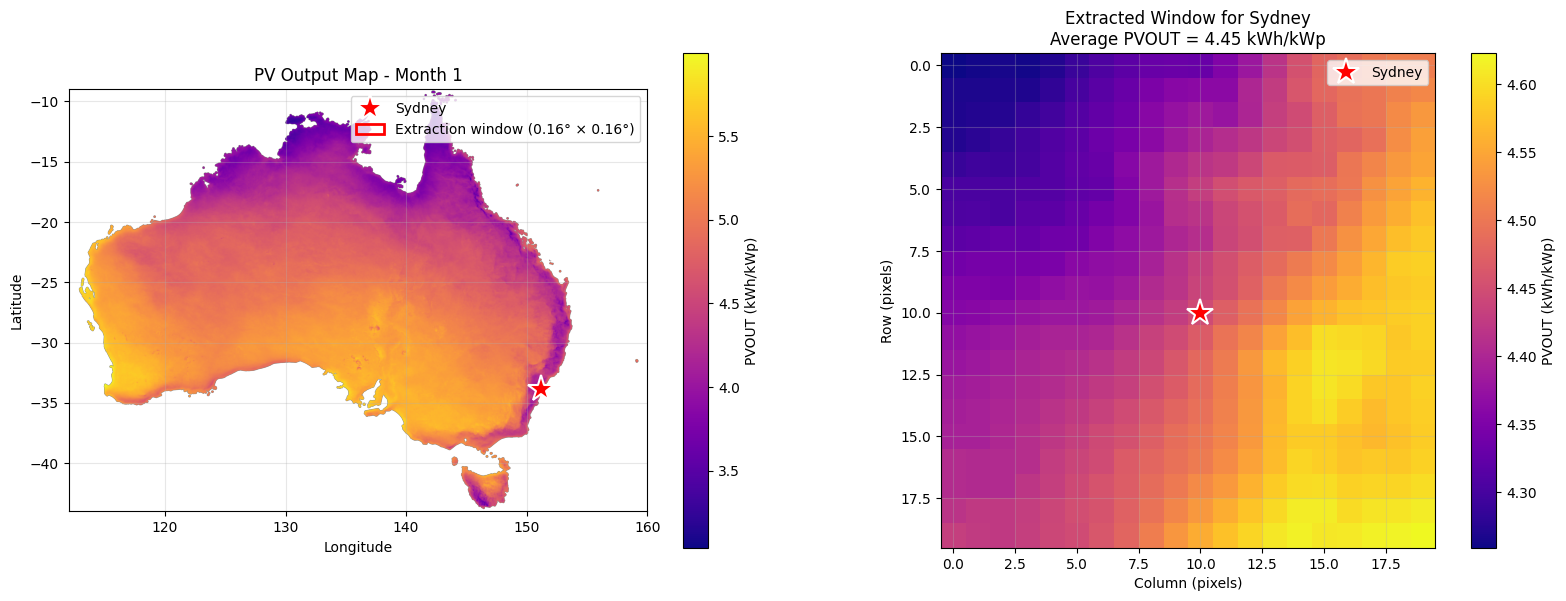

Sample Calculation for Sydney (Month 1):
   - City coordinates: (-33.8678°, 151.2100°)
   - Extraction window: ±0.08° buffer (≈8.9 km)
   - Window bounds: (151.125, -33.95, 151.29166666666666, -33.78333333333333)
   - Extracted data shape: (20, 20) pixels
   - Non-masked pixels: 400 / 400
   - Calculated avg_value: 4.4514 kWh/kWp
   - Value range in window: 4.26 - 4.62 kWh/kWp


In [50]:
# Visualize sample avg_value calculation on map
# Show how we extract solar data for a specific city from the TIFF raster

# Pick a sample city and month for visualization
sample_city = "Sydney"
sample_month = 1  # January
sample_month_path = monthly_paths[sample_month - 1]

# Get city coordinates
sample_lat, sample_lon = city_coords[sample_city]

# Open the raster and extract the window
with rasterio.open(sample_month_path) as src:
    # Read full raster for context
    full_raster = src.read(1, masked=True)

    # Calculate window bounds
    window = from_bounds(
        sample_lon - buffer_deg,
        sample_lat - buffer_deg,
        sample_lon + buffer_deg,
        sample_lat + buffer_deg,
        src.transform,
    )

    # Extract the data window (same as in main loop)
    row_start = int(np.floor(window.row_off))
    col_start = int(np.floor(window.col_off))
    row_stop = int(np.ceil(window.row_off + window.height))
    col_stop = int(np.ceil(window.col_off + window.width))
    height = max(1, row_stop - row_start)
    width = max(1, col_stop - col_start)
    tight_window = Window(col_start, row_start, width, height)

    # Extract data
    extracted_data = src.read(
        1, window=tight_window, masked=True, boundless=True, fill_value=np.nan
    )
    extracted_avg = float(extracted_data.mean())

    # Get extent for plotting
    full_extent = plotting_extent(full_raster, src.transform)

    # Calculate the bounding box in map coordinates
    window_bounds = rasterio.windows.bounds(tight_window, src.transform)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Full raster with city location and extraction box
ax1 = axes[0]
img1 = ax1.imshow(full_raster, cmap="plasma", extent=full_extent, origin="upper")
plt.colorbar(img1, ax=ax1, label="PVOUT (kWh/kWp)")

# Plot city location
ax1.plot(
    sample_lon,
    sample_lat,
    "r*",
    markersize=20,
    label=f"{sample_city}",
    markeredgecolor="white",
    markeredgewidth=1.5,
)

# Plot extraction window as rectangle
from matplotlib.patches import Rectangle

rect = Rectangle(
    (window_bounds[0], window_bounds[1]),  # (left, bottom)
    window_bounds[2] - window_bounds[0],  # width
    window_bounds[3] - window_bounds[1],  # height
    linewidth=2,
    edgecolor="red",
    facecolor="none",
    label=f"Extraction window ({buffer_deg*2:.2f}° × {buffer_deg*2:.2f}°)",
)
ax1.add_patch(rect)

ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.set_title(f"PV Output Map - Month {sample_month}")
ax1.legend(loc="upper right")
ax1.grid(True, alpha=0.3)

# Right plot: Zoomed extracted region
ax2 = axes[1]
img2 = ax2.imshow(extracted_data, cmap="plasma", origin="upper")
plt.colorbar(img2, ax=ax2, label="PVOUT (kWh/kWp)")

# Add city marker at approximate center
center_row = extracted_data.shape[0] // 2
center_col = extracted_data.shape[1] // 2
ax2.plot(
    center_col,
    center_row,
    "r*",
    markersize=20,
    label=f"{sample_city}",
    markeredgecolor="white",
    markeredgewidth=1.5,
)

ax2.set_xlabel("Column (pixels)")
ax2.set_ylabel("Row (pixels)")
ax2.set_title(
    f"Extracted Window for {sample_city}\nAverage PVOUT = {extracted_avg:.2f} kWh/kWp"
)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Sample Calculation for {sample_city} (Month {sample_month}):")
print(f"   - City coordinates: ({sample_lat:.4f}°, {sample_lon:.4f}°)")
print(f"   - Extraction window: ±{buffer_deg}° buffer (≈{buffer_deg*111:.1f} km)")
print(f"   - Window bounds: {window_bounds}")
print(f"   - Extracted data shape: {extracted_data.shape} pixels")
print(f"   - Non-masked pixels: {(~extracted_data.mask).sum()} / {extracted_data.size}")
print(f"   - Calculated avg_value: {extracted_avg:.4f} kWh/kWp")
print(
    f"   - Value range in window: {extracted_data.min():.2f} - {extracted_data.max():.2f} kWh/kWp"
)

In [51]:
daily_solar_records = []
start_date = pd.Timestamp("2016-07-01")
end_date = pd.Timestamp("2017-06-30")

print("Generating synthetic daily solar data...")
print("Method: Monthly PVOUT baseline + random noise")

# For each location, generate 365 days of solar data
for location in city_coords.keys():
    lat, lon = city_coords[location]
    current_date = start_date
    day_counter = 0

    while current_date <= end_date and day_counter < 365:
        month = current_date.month

        # Get monthly average for this location and month
        monthly_avg_row = solar_monthly_df[
            (solar_monthly_df["Location"] == location)
            & (solar_monthly_df["Month"] == month)
        ]

        if len(monthly_avg_row) > 0:
            monthly_avg = monthly_avg_row.iloc[0]["pvout_monthly_avg"]

            # Generate daily value as monthly baseline + random variation
            # Random noise represents day-to-day unpredictability (±10%)
            # This allows weather features to predict deviations from monthly mean
            noise = np.random.normal(0, 0.10 * monthly_avg)
            daily_value = monthly_avg + noise

            # Ensure no negative values
            daily_value = max(daily_value, 0.01)

            daily_solar_records.append(
                {"Location": location, "Date": current_date, "pvout": daily_value}
            )

        current_date += pd.Timedelta(days=1)
        day_counter += 1

solar_daily_df = pd.DataFrame(daily_solar_records)

print(f"✓ Daily solar data generated: {len(solar_daily_df)} records")
print(f"Date range: {solar_daily_df['Date'].min()} to {solar_daily_df['Date'].max()}")
print(f"Locations: {solar_daily_df['Location'].nunique()}")
print(f"Days per location: {solar_daily_df.groupby('Location').size().unique()}")
display(solar_daily_df.head())

Generating synthetic daily solar data...
Method: Monthly PVOUT baseline + random noise
✓ Daily solar data generated: 17520 records
Date range: 2016-07-01 00:00:00 to 2017-06-30 00:00:00
Locations: 48
Days per location: [365]


,Location,Date,pvout
0,Albury,2016-07-01,2.737947
1,Albury,2016-07-02,3.343850
2,Albury,2016-07-03,2.950114
3,Albury,2016-07-04,2.750610
4,Albury,2016-07-05,2.922208


MONTHLY PVOUT BASELINES

Daily synthetic values = Monthly PVOUT + random noise (±15%)
Note: Monthly PVOUT already includes weather AND solar geometry


Melbourne (Latitude: -37.81°)
------------------------------------------------------------
  Jan (Summer): Monthly baseline = 5.02 kWh/m²/day
  Apr (Autumn): Monthly baseline = 3.53 kWh/m²/day
  Jul (Winter): Monthly baseline = 2.67 kWh/m²/day
  Oct (Spring): Monthly baseline = 4.35 kWh/m²/day

Brisbane (Latitude: -27.47°)
------------------------------------------------------------
  Jan (Summer): Monthly baseline = 4.20 kWh/m²/day
  Apr (Autumn): Monthly baseline = 4.33 kWh/m²/day
  Jul (Winter): Monthly baseline = 4.29 kWh/m²/day
  Oct (Spring): Monthly baseline = 4.74 kWh/m²/day



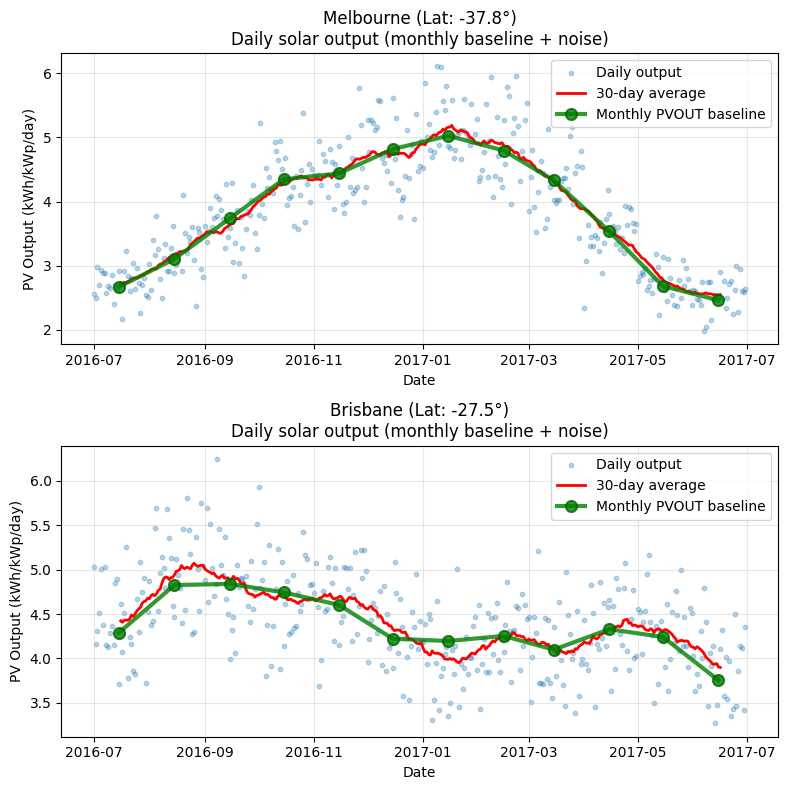


SEASONAL ANALYSIS: Summer vs Winter Solar Output

Comparing summer (January) vs winter (July) solar output by latitude:



,City,Latitude,Jan (Summer),Jul (Winter),Summer/Winter Ratio
0,Melbourne,-37.8°,5.16,2.72,1.90x
1,Brisbane,-27.5°,3.99,4.43,0.90x


In [52]:
# Visualize physics-based patterns for sample cities at different latitudes
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

sample_cities = ["Melbourne", "Brisbane"]

# Print monthly baselines for sample cities
print("=" * 80)
print("MONTHLY PVOUT BASELINES")
print("=" * 80)
print("\nDaily synthetic values = Monthly PVOUT + random noise (±15%)")
print("Note: Monthly PVOUT already includes weather AND solar geometry\n")

for city in sample_cities:
    lat, lon = city_coords[city]
    print(f"\n{city} (Latitude: {lat:.2f}°)")
    print("-" * 60)

    # Show monthly values for Jan (summer), Apr (autumn), Jul (winter), Oct (spring)
    sample_months = [1, 4, 7, 10]
    month_names = ["Jan (Summer)", "Apr (Autumn)", "Jul (Winter)", "Oct (Spring)"]

    for month, month_name in zip(sample_months, month_names):
        monthly_avg_row = solar_monthly_df[
            (solar_monthly_df["Location"] == city)
            & (solar_monthly_df["Month"] == month)
        ]

        if len(monthly_avg_row) > 0:
            monthly_avg = monthly_avg_row.iloc[0]["pvout_monthly_avg"]
            print(f"  {month_name}: Monthly baseline = {monthly_avg:.2f} kWh/m²/day")

print("\n" + "=" * 80)

for idx, city in enumerate(sample_cities):
    ax = axes[idx]

    city_data = (
        solar_daily_df[solar_daily_df["Location"] == city].sort_values("Date").copy()
    )

    if len(city_data) > 0:
        # Add month for grouping
        city_data["Month"] = city_data["Date"].dt.month

        # Plot daily values
        ax.scatter(
            city_data["Date"], city_data["pvout"], alpha=0.3, s=10, label="Daily output"
        )

        # Plot monthly rolling average
        city_data["rolling_avg"] = (
            city_data["pvout"].rolling(window=30, center=True).mean()
        )
        ax.plot(
            city_data["Date"],
            city_data["rolling_avg"],
            "r-",
            linewidth=2,
            label="30-day average",
        )

        # Plot monthly PVOUT baseline (from TIFF files)
        # Get monthly baseline values for this city
        city_monthly = solar_monthly_df[solar_monthly_df["Location"] == city].copy()
        if len(city_monthly) > 0:
            # Create dates for the middle of each month, matching the time series order
            city_monthly["plot_date"] = city_monthly["Month"].apply(
                lambda m: (
                    pd.Timestamp(f"2016-{m:02d}-15")
                    if m >= 7
                    else pd.Timestamp(f"2017-{m:02d}-15")
                )
            )
            # Sort by the actual date to ensure proper chronological order
            city_monthly = city_monthly.sort_values("plot_date")

            ax.plot(
                city_monthly["plot_date"],
                city_monthly["pvout_monthly_avg"],
                "go-",
                linewidth=3,
                markersize=8,
                label="Monthly PVOUT baseline",
                alpha=0.8,
                markeredgecolor="darkgreen",
                markeredgewidth=1.5,
            )

        lat = city_coords[city][0]
        ax.set_xlabel("Date")
        ax.set_ylabel("PV Output (kWh/kWp/day)")
        ax.set_title(
            f"{city} (Lat: {lat:.1f}°)\nDaily solar output (monthly baseline + noise)"
        )
        ax.legend(loc="best")
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare seasonal patterns across latitudes
print("\n" + "=" * 80)
print("SEASONAL ANALYSIS: Summer vs Winter Solar Output")
print("=" * 80)
print("\nComparing summer (January) vs winter (July) solar output by latitude:\n")

seasonal_comparison = []
for city in sample_cities:
    lat = city_coords[city][0]
    city_data = solar_daily_df[solar_daily_df["Location"] == city].copy()
    city_data["Month"] = city_data["Date"].dt.month

    jan_avg = city_data[city_data["Month"] == 1]["pvout"].mean()
    jul_avg = city_data[city_data["Month"] == 7]["pvout"].mean()
    ratio = jan_avg / jul_avg if jul_avg > 0 else 0

    seasonal_comparison.append(
        {
            "City": city,
            "Latitude": f"{lat:.1f}°",
            "Jan (Summer)": f"{jan_avg:.2f}",
            "Jul (Winter)": f"{jul_avg:.2f}",
            "Summer/Winter Ratio": f"{ratio:.2f}x",
        }
    )

comparison_df = pd.DataFrame(seasonal_comparison)
display(comparison_df)

/var/folders/0_/mjcn_20x08nfpt2yg090ghtr0000gn/T/ipykernel_7441/2355873246.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.96])


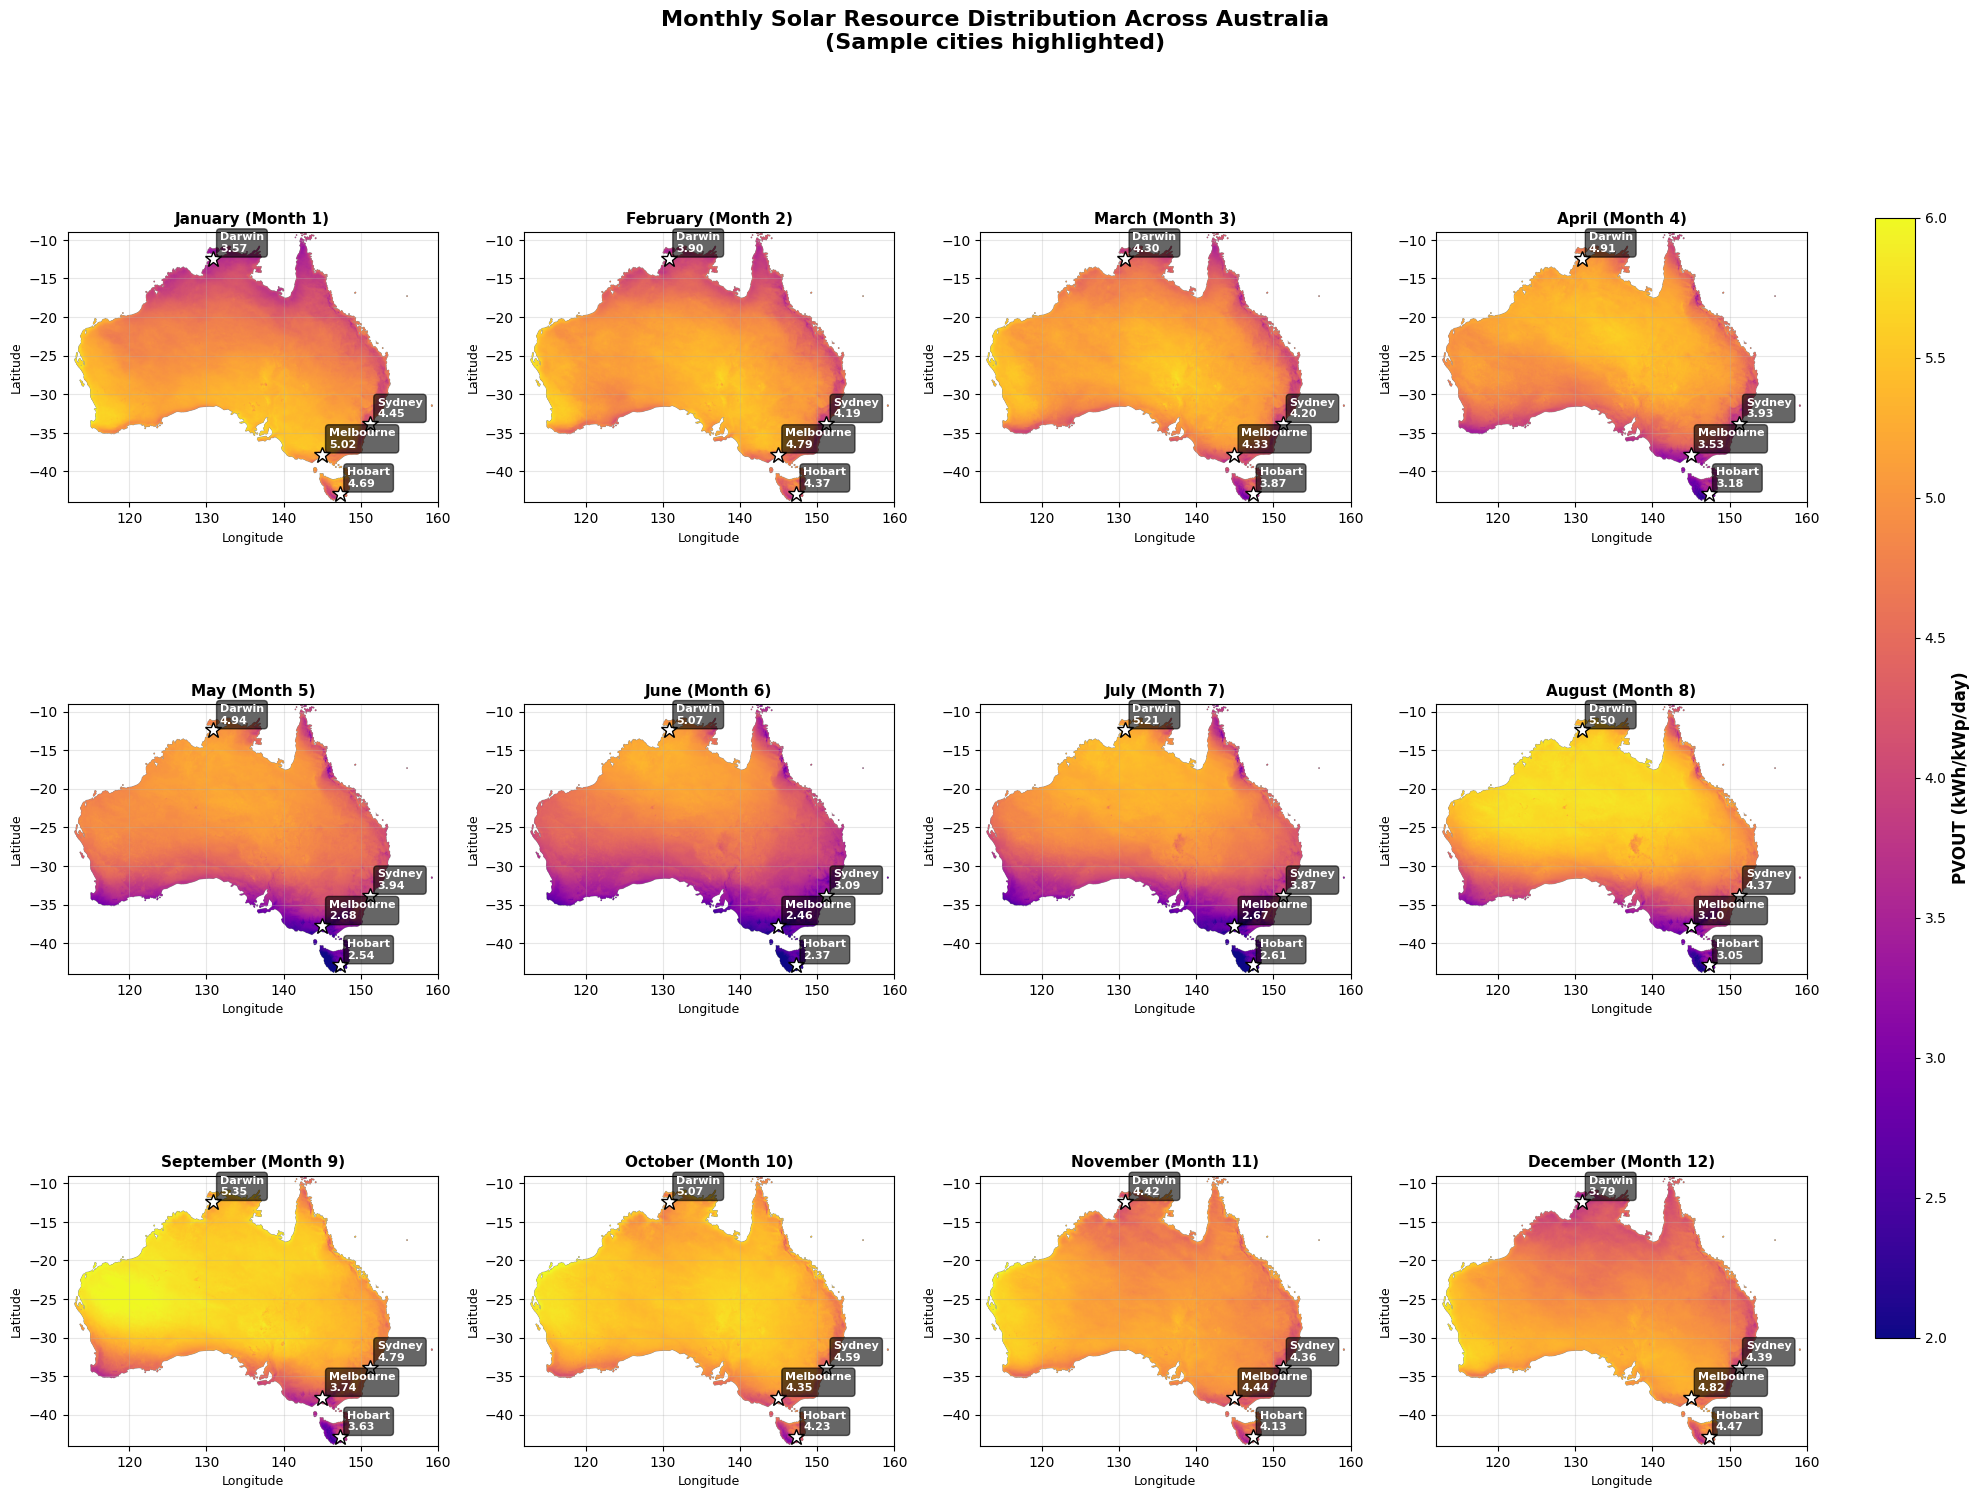

In [53]:
# Visualize monthly PVOUT on geotiff maps
# Show how solar resources vary geographically and seasonally across Australia

fig, axes = plt.subplots(3, 4, figsize=(20, 16))
axes = axes.flatten()

# Select sample cities to highlight
highlight_cities = ["Darwin", "Sydney", "Melbourne", "Hobart"]

for month_idx, month_path in enumerate(monthly_paths):
    month_number = int(month_path.stem.split("_")[-1])
    month_label = pd.Timestamp(year=2016, month=month_number, day=1).strftime("%B")

    ax = axes[month_idx]

    # Read and display the monthly PVOUT raster
    with rasterio.open(month_path) as src:
        monthly_raster = src.read(1, masked=True)
        extent = plotting_extent(monthly_raster, src.transform)

        # Plot the raster
        img = ax.imshow(
            monthly_raster, cmap="plasma", extent=extent, origin="upper", vmin=2, vmax=6
        )

    # Overlay sample city locations
    for city in highlight_cities:
        if city in city_coords:
            lat, lon = city_coords[city]
            # Get the monthly PVOUT value for this city
            city_value = solar_monthly_df[
                (solar_monthly_df["Location"] == city)
                & (solar_monthly_df["Month"] == month_number)
            ]
            if len(city_value) > 0:
                pvout_val = city_value.iloc[0]["pvout_monthly_avg"]
                ax.plot(
                    lon,
                    lat,
                    "w*",
                    markersize=12,
                    markeredgecolor="black",
                    markeredgewidth=1,
                )
                ax.annotate(
                    f"{city}\n{pvout_val:.2f}",
                    xy=(lon, lat),
                    xytext=(5, 5),
                    textcoords="offset points",
                    fontsize=8,
                    color="white",
                    weight="bold",
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="black", alpha=0.6),
                )

    ax.set_xlabel("Longitude", fontsize=9)
    ax.set_ylabel("Latitude", fontsize=9)
    ax.set_title(
        f"{month_label} (Month {month_number})", fontsize=11, fontweight="bold"
    )
    ax.grid(True, alpha=0.3)

# Add colorbar
fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
cbar = fig.colorbar(img, cax=cbar_ax, label="PVOUT (kWh/kWp/day)")
cbar.set_label("PVOUT (kWh/kWp/day)", fontsize=12, fontweight="bold")

fig.suptitle(
    "Monthly Solar Resource Distribution Across Australia\n(Sample cities highlighted)",
    fontsize=16,
    fontweight="bold",
    y=0.98,
)

plt.tight_layout(rect=[0, 0, 0.92, 0.96])
plt.show()

In [54]:
# Prepare weather data
weather_df = df.copy()
weather_df["RainToday"] = weather_df["RainToday"].map({"Yes": 1, "No": 0})

# Merge weather and solar data on Location and Date
model_dataset = weather_df.merge(solar_daily_df, on=["Location", "Date"], how="inner")

# Handle missing values
print(f"Dataset shape before handling missing values: {model_dataset.shape}")
print(f"\nMissing values per column:")
missing_cols = model_dataset.isnull().sum()[model_dataset.isnull().sum() > 0]
display(missing_cols)

# Fill missing values with median for numeric columns
numeric_cols = model_dataset.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if model_dataset[col].isnull().any():
        median_val = model_dataset[col].median()
        model_dataset[col] = model_dataset[col].fillna(median_val)
        print(f"Filled {col} with median: {median_val:.2f}")

# Handle any remaining NaN values in non-numeric columns (string/object columns)
for col in model_dataset.columns:
    if model_dataset[col].isnull().any():
        if model_dataset[col].dtype in ["object", "string"]:
            model_dataset[col] = model_dataset[col].fillna("Unknown")
            print(f"Filled {col} (object) with 'Unknown'")

print(f"\nDataset shape after handling missing values: {model_dataset.shape}")
print(f"Remaining NaN values: {model_dataset.isnull().sum().sum()}")

# Verify no NaN values remain
assert model_dataset.isnull().sum().sum() == 0

Dataset shape before handling missing values: (17520, 28)

Missing values per column:


MinTemp           125
MaxTemp            64
Rainfall          165
Evaporation      6495
Sunshine         7095
WindGustDir      1411
WindGustSpeed    1408
WindDir9am       1232
WindDir3pm        338
WindSpeed9am      221
WindSpeed3pm      204
Humidity9am       248
Humidity3pm       293
Pressure9am      1534
Pressure3pm      1536
Cloud9am         6161
Cloud3pm         6375
Temp9am           181
Temp3pm           194
RainToday         165
dtype: int64

Filled MinTemp with median: 12.40
Filled MaxTemp with median: 23.50
Filled Rainfall with median: 0.00
Filled Evaporation with median: 5.00
Filled Sunshine with median: 8.80
Filled WindGustSpeed with median: 39.00
Filled WindSpeed9am with median: 13.00
Filled WindSpeed3pm with median: 19.00
Filled Humidity9am with median: 69.00
Filled Humidity3pm with median: 50.00
Filled Pressure9am with median: 1017.00
Filled Pressure3pm with median: 1014.60
Filled Cloud9am with median: 4.00
Filled Cloud3pm with median: 5.00
Filled Temp9am with median: 17.00
Filled Temp3pm with median: 22.10
Filled RainToday with median: 0.00
Filled WindGustDir (object) with 'Unknown'
Filled WindDir9am (object) with 'Unknown'
Filled WindDir3pm (object) with 'Unknown'

Dataset shape after handling missing values: (17520, 28)
Remaining NaN values: 0


In [56]:
# Add cyclical encoding for Month (since months are periodic: Dec -> Jan)
# This preserves the circular nature of seasonal patterns
model_dataset["month_sin"] = np.sin(2 * np.pi * model_dataset["Month"] / 12)
model_dataset["month_cos"] = np.cos(2 * np.pi * model_dataset["Month"] / 12)

print("Added cyclical month encoding:")
print(f"  - month_sin: sin(2π × Month / 12)")
print(f"  - month_cos: cos(2π × Month / 12)")

Added cyclical month encoding:
  - month_sin: sin(2π × Month / 12)
  - month_cos: cos(2π × Month / 12)


In [57]:
# Define feature columns (exclude Location, Date, Month, and target)
feature_columns = [
    col
    for col in model_dataset.columns
    if col not in {"Location", "Date", "Month", "pvout", "RainTomorrow"}
    and model_dataset[col].dtype in [np.float64, np.int64]
]

X = model_dataset[feature_columns]
y = model_dataset["pvout"]

# Verify no NaN values in features
print(f"\nFeature columns ({len(feature_columns)}): {feature_columns}")
print(f"NaN values in X: {X.isnull().sum().sum()}")
print(f"NaN values in y: {y.isnull().sum()}")

# Drop any rows with remaining NaN values
if X.isnull().any().any() or y.isnull().any():
    print("\nDropping rows with remaining NaN values...")
    valid_indices = X.notnull().all(axis=1) & y.notnull()
    X = X[valid_indices].reset_index(drop=True)
    y = y[valid_indices].reset_index(drop=True)
    print(f"Final dataset shape: {X.shape}")


Feature columns (21): ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'Latitude', 'Longitude', 'month_sin', 'month_cos']
NaN values in X: 0
NaN values in y: 0


## **Time-Based Train/Test Split**

To properly evaluate model performance while respecting temporal structure:
- **Training set**: July 1, 2016 - March 31, 2017 (9 months)
- **Test set**: April 1, 2017 - June 30, 2017 (3 months)

This approach:
- Prevents temporal leakage (no training on future data)
- Tests the model's ability to generalize to future time periods

In [59]:
# Perform time-based split
# Sort dataset by date to ensure proper temporal ordering
model_dataset_sorted = model_dataset.sort_values('Date').reset_index(drop=True)

# Define split date: 9 months for training, 3 months for testing
split_date = pd.Timestamp('2017-04-01')

# Create train/test masks
train_mask = model_dataset_sorted['Date'] < split_date
test_mask = model_dataset_sorted['Date'] >= split_date

# Split features and target
X_train = model_dataset_sorted.loc[train_mask, feature_columns].copy()
X_test = model_dataset_sorted.loc[test_mask, feature_columns].copy()
y_train = model_dataset_sorted.loc[train_mask, 'pvout'].copy()
y_test = model_dataset_sorted.loc[test_mask, 'pvout'].copy()

print("\nTime-Based Train/Test Split:")
print("=" * 70)
print(f"Training set:")
print(f"  Date range: {model_dataset_sorted.loc[train_mask, 'Date'].min()} to {model_dataset_sorted.loc[train_mask, 'Date'].max()}")
print(f"  Size: {len(X_train)} observations ({len(X_train)/len(model_dataset_sorted)*100:.1f}%)")
print(f"  Locations: {model_dataset_sorted.loc[train_mask, 'Location'].nunique()}")
print(f"\nTest set:")
print(f"  Date range: {model_dataset_sorted.loc[test_mask, 'Date'].min()} to {model_dataset_sorted.loc[test_mask, 'Date'].max()}")
print(f"  Size: {len(X_test)} observations ({len(X_test)/len(model_dataset_sorted)*100:.1f}%)")
print(f"  Locations: {model_dataset_sorted.loc[test_mask, 'Location'].nunique()}")
print("=" * 70)


Time-Based Train/Test Split:
Training set:
  Date range: 2016-07-01 00:00:00 to 2017-03-31 00:00:00
  Size: 13152 observations (75.1%)
  Locations: 48

Test set:
  Date range: 2017-04-01 00:00:00 to 2017-06-30 00:00:00
  Size: 4368 observations (24.9%)
  Locations: 48


In [60]:
# Initialize models
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

rf = RandomForestRegressor(n_estimators=150, random_state=42, n_jobs=-1)
ridge = Ridge(alpha=1.0)
xgb = XGBRegressor(n_estimators=150, random_state=42, learning_rate=0.1)
linear = LinearRegression()

models = {
    'Random Forest': rf,
    'XGBoost': xgb,
    'Ridge': ridge,
    'Linear Regression': linear
}

# Train and evaluate each model
results = []

print("\nTraining and evaluating models...")
print("=" * 70)

for model_name, model in models.items():
    print(f"\n{model_name}:")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    results.append({
        'model': model_name,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse
    })
    
    print(f"  Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")
    print(f"  Train MAE: {train_mae:.4f} | Test MAE: {test_mae:.4f}")
    print(f"  Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")

print("\n" + "=" * 70)

# Create results dataframe
results_df = pd.DataFrame(results).sort_values('test_r2', ascending=False)

print("\nModel Performance Summary (sorted by Test R²):")
display(results_df)


Training and evaluating models...

Random Forest:
  Train R²: 0.9533 | Test R²: 0.4632
  Train MAE: 0.1427 | Test MAE: 0.4809
  Train RMSE: 0.1809 | Test RMSE: 0.6115

XGBoost:
  Train R²: 0.7881 | Test R²: 0.4553
  Train MAE: 0.3023 | Test MAE: 0.4842
  Train RMSE: 0.3855 | Test RMSE: 0.6160

Ridge:
  Train R²: 0.2600 | Test R²: 0.2682
  Train MAE: 0.5816 | Test MAE: 0.5831
  Train RMSE: 0.7204 | Test RMSE: 0.7140

Linear Regression:
  Train R²: 0.2600 | Test R²: 0.2684
  Train MAE: 0.5816 | Test MAE: 0.5830
  Train RMSE: 0.7204 | Test RMSE: 0.7139


Model Performance Summary (sorted by Test R²):


,model,train_r2,test_r2,train_mae,test_mae,train_rmse,test_rmse
0,Random Forest,0.953321,0.463248,0.142675,0.480857,0.180940,0.611505
1,XGBoost,0.788069,0.455317,0.302346,0.484222,0.385544,0.616007
3,Linear Regression,0.260015,0.268355,0.581602,0.583006,0.720424,0.713943
2,Ridge,0.260015,0.268215,0.581600,0.583063,0.720424,0.714012


In [61]:
# Get feature importances from best models
rf_feature_importances = pd.Series(
    rf.feature_importances_, index=feature_columns
).sort_values(ascending=False)

xgb_feature_importances = pd.Series(
    xgb.feature_importances_, index=feature_columns
).sort_values(ascending=False)

print("Top 10 Feature Importances (Random Forest):")
display(rf_feature_importances.head(10).to_frame(name="RF_importance"))

print("\nTop 10 Feature Importances (XGBoost):")
display(xgb_feature_importances.head(10).to_frame(name="XGB_importance"))

Top 10 Feature Importances (Random Forest):


,RF_importance
Latitude,0.260496
month_cos,0.232175
Longitude,0.120472
month_sin,0.074205
MinTemp,0.026922
Humidity9am,0.024787
Humidity3pm,0.024713
Temp9am,0.024229
Pressure3pm,0.022373
MaxTemp,0.021455



Top 10 Feature Importances (XGBoost):


,XGB_importance
month_cos,0.491655
Latitude,0.200780
Longitude,0.109773
month_sin,0.082589
Temp3pm,0.010331
Humidity3pm,0.008402
Temp9am,0.008333
Sunshine,0.007570
Humidity9am,0.007359
Pressure9am,0.007349


In [62]:
# Save the modeling dataset and trained models for use with the agent
model_dataset.to_csv("solar_weather_dataset.csv", index=False)
print(f"Modeling dataset saved to solar_weather_dataset.csv ({len(model_dataset)} daily observations)")

# Save the trained models (using best-performing models from time-based split)
import pickle

with open("solar_rf_model.pkl", "wb") as f:
    pickle.dump(rf, f)
print(f"Trained Random Forest model saved to solar_rf_model.pkl")
print(f"  Test R²: {results_df[results_df['model'] == 'Random Forest']['test_r2'].values[0]:.4f}")

with open("solar_xgb_model.pkl", "wb") as f:
    pickle.dump(xgb, f)
print(f"Trained XGBoost model saved to solar_xgb_model.pkl")
print(f"  Test R²: {results_df[results_df['model'] == 'XGBoost']['test_r2'].values[0]:.4f}")

# Save feature columns for later use
with open("model_features.pkl", "wb") as f:
    pickle.dump(feature_columns, f)
print(f"\nFeature columns saved to model_features.pkl ({len(feature_columns)} features)")

# Save train/test split info
split_info = {
    'split_date': split_date,
    'train_size': len(X_train),
    'test_size': len(X_test),
    'train_date_range': (model_dataset_sorted.loc[train_mask, 'Date'].min(), 
                         model_dataset_sorted.loc[train_mask, 'Date'].max()),
    'test_date_range': (model_dataset_sorted.loc[test_mask, 'Date'].min(), 
                        model_dataset_sorted.loc[test_mask, 'Date'].max())
}
with open("split_info.pkl", "wb") as f:
    pickle.dump(split_info, f)
print(f"Split information saved to split_info.pkl")

Modeling dataset saved to solar_weather_dataset.csv (17520 daily observations)
Trained Random Forest model saved to solar_rf_model.pkl
  Test R²: 0.4632
Trained XGBoost model saved to solar_xgb_model.pkl
  Test R²: 0.4553

Feature columns saved to model_features.pkl (21 features)
Split information saved to split_info.pkl


/var/folders/0_/mjcn_20x08nfpt2yg090ghtr0000gn/T/ipykernel_7441/2660610595.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(models_sorted, rotation=45, ha='right')
/var/folders/0_/mjcn_20x08nfpt2yg090ghtr0000gn/T/ipykernel_7441/2660610595.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(models_sorted, rotation=45, ha='right')


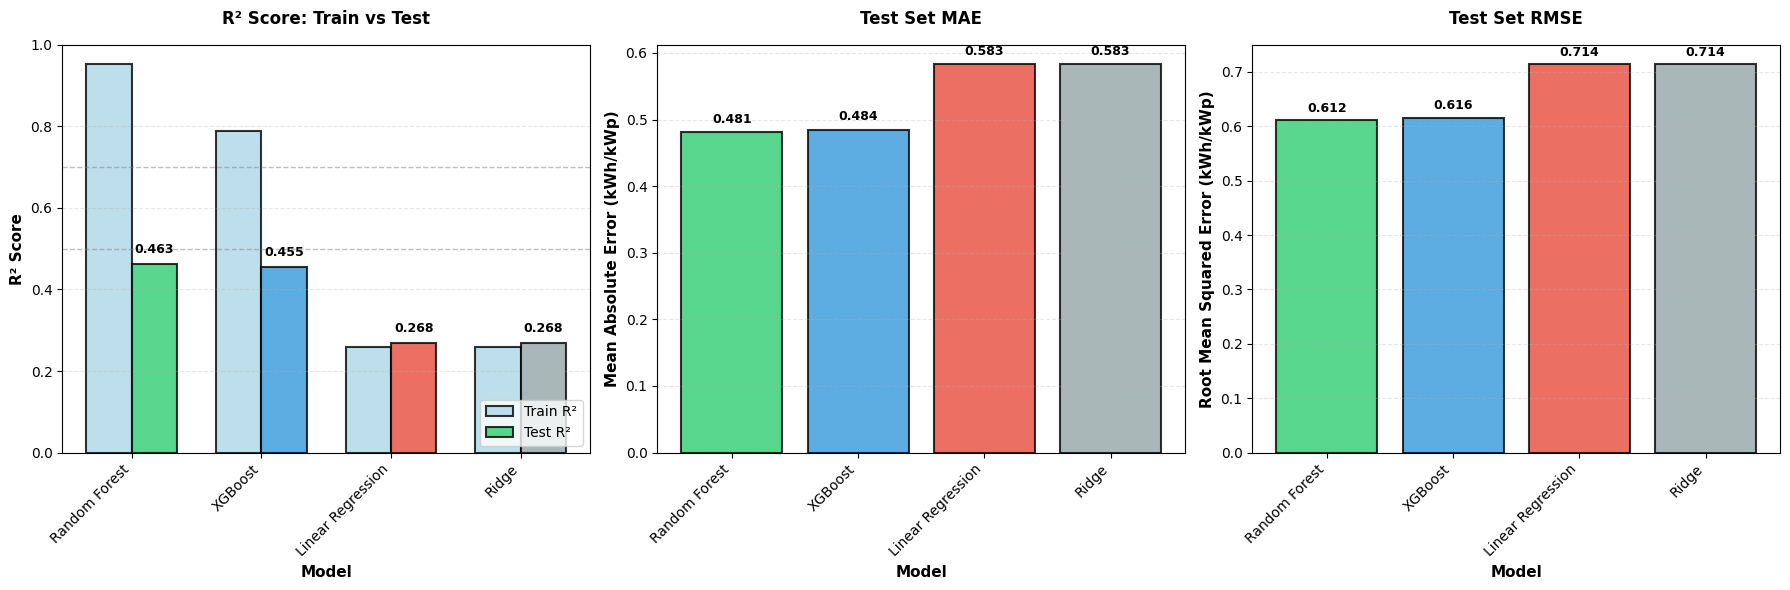

In [65]:
# Visualize model performance comparison (Train vs Test)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Sort results by test R²
results_df_sorted = results_df.sort_values('test_r2', ascending=False)
models_sorted = results_df_sorted['model'].tolist()
train_r2_sorted = results_df_sorted['train_r2'].tolist()
test_r2_sorted = results_df_sorted['test_r2'].tolist()
test_mae_sorted = results_df_sorted['test_mae'].tolist()
test_rmse_sorted = results_df_sorted['test_rmse'].tolist()

colors = ['#2ecc71', '#3498db', '#e74c3c', '#95a5a6']

# Plot 1: R² Score Comparison
ax1 = axes[0]
x = np.arange(len(models_sorted))
width = 0.35

bars1 = ax1.bar(x - width/2, train_r2_sorted, width, label='Train R²', 
                color='lightblue', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax1.bar(x + width/2, test_r2_sorted, width, label='Test R²', 
                color=colors[:len(models_sorted)], alpha=0.8, edgecolor='black', linewidth=1.5)

ax1.set_ylabel('R² Score', fontsize=11, fontweight='bold')
ax1.set_xlabel('Model', fontsize=11, fontweight='bold')
ax1.set_title('R² Score: Train vs Test', fontsize=12, fontweight='bold', pad=15)
ax1.set_xticks(x)
ax1.set_xticklabels(models_sorted, rotation=45, ha='right')
ax1.legend(loc='lower right')
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax1.axhline(y=0.7, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax1.set_ylim(0, 1.0)

# Add value labels
for i, (bar, val) in enumerate(zip(bars2, test_r2_sorted)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2.0, height + 0.02,
             f'{val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Plot 2: Test MAE
ax2 = axes[1]
bars = ax2.bar(models_sorted, test_mae_sorted, color=colors[:len(models_sorted)], 
               alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Mean Absolute Error (kWh/kWp)', fontsize=11, fontweight='bold')
ax2.set_xlabel('Model', fontsize=11, fontweight='bold')
ax2.set_title('Test Set MAE', fontsize=12, fontweight='bold', pad=15)
ax2.set_xticklabels(models_sorted, rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

for bar, val in zip(bars, test_mae_sorted):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2.0, height + 0.01,
             f'{val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Plot 3: Test RMSE
ax3 = axes[2]
bars = ax3.bar(models_sorted, test_rmse_sorted, color=colors[:len(models_sorted)], 
               alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Root Mean Squared Error (kWh/kWp)', fontsize=11, fontweight='bold')
ax3.set_xlabel('Model', fontsize=11, fontweight='bold')
ax3.set_title('Test Set RMSE', fontsize=12, fontweight='bold', pad=15)
ax3.set_xticklabels(models_sorted, rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3, linestyle='--')

for bar, val in zip(bars, test_rmse_sorted):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width() / 2.0, height + 0.01,
             f'{val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()